### **Lunar Lander DQN KERAS using Clases**

This is a naive version of the Lunar Lander DQN algorithm using an Agent Class<br>
<br>
In this version the agent has been created as a class making the code more compact <br>
This DQN Class can be used with other environments <br>
 <br>
Try to make it faster by doing some hyperparameter optimization  <br>
Try to explore less. Does it accelerates convergence?  <br>
Increasing the ```ROLLING_WINDOW``` value will gnerate slower agent convergence but the Agent behavior will be more consistent <br>

An issue you may find is a lander that hovers forever. This happens because it has been programmed with infinite fuel. You can see it in this execution in the lines that are marked as ```Terminated=False```. This confuses the training because it does not reach the objective or termination. Without modifying the environment, there are a couple of things that can be done to ameliorate this behavior <br>

1. **Limit number of steps** In this case we are limiting the number of steps to 1200, if you don't limit it sometimes it goes up to thousands of steps, and this is a waste of time
2. **Increase gravity** The default gravity in this environment is -10.0, you can increase it up to -12.0, increasing it you'll have a faster descent and hovering becomes more difficult ```env = gym.make("LunarLander-v3", gravity=11.0)```

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import random
import gymnasium as gym
import time
import numpy as np
from collections import deque
from keras.models import Sequential, Model
from keras.layers import Dense, Input
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from PIL import Image
import time

# Use mixed-precision training for faster computations on supported GPUs
from tensorflow.keras.mixed_precision import set_global_policy
set_global_policy('mixed_float16')

import sys
sys.stderr = open('err.txt', 'w')

I0000 00:00:1739030414.386462  673141 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1739030414.405684  673141 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1739030414.405721  673141 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1739030414.591993  673141 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1739030414.592040  673141 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

In [2]:
from tensorflow.python.client import device_lib
devices = device_lib.list_local_devices()
gpu_devices = [device for device in devices if device.device_type == 'GPU']
for gpu in gpu_devices:
    print('Using', gpu.physical_device_desc)

Using device: 0, name: NVIDIA T600 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 7.5


#### **Hyperparameters**

In [3]:

MAX_EPISODES = 2000
ROLLING_WINDOW = 40
MEMORY_SIZE = 100000
MAX_STEPS = 1200

gamma = 0.99                         # discount rate
epsilon = 1.0                        # exploration rate
epsilon_min = 0.01
epsilon_decay = 0.99
learning_rate = 0.0001
batch_size = 64
solved_threshold = 200

verb = 0                             # to see traces (verbosity)

In [4]:
# Environment setup
env = gym.make('LunarLander-v3')
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

In [5]:
class Agent_DQN():
    def __init__(self, states, actions, alpha, gamma, epsilon):
        self.nS = states
        self.nA = actions
        self.replay_buffer = deque([], maxlen=MEMORY_SIZE)
        self.alpha = alpha
        self.gamma = gamma
        #Explore/Exploit
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.model = self.build_NN()
        self.loss = []

    def build_NN(self):
        inputs = Input(shape=(state_size,), name="state_input")
        x = Dense(128, activation='relu', name="dense_1")(inputs)
        x = Dense(64, activation='relu', name="dense_2")(x)
        x = Dense(32, activation='relu', name="dense_3")(x)
        outputs = Dense(action_size, activation='linear', name="output_layer")(x)
        model = Model(inputs=inputs, outputs=outputs, name="Q_Network")
        model.compile(loss='mse', optimizer=Adam(learning_rate=learning_rate))
        model.summary()
        return model

    def action(self, state):
        action_vals = self.model.predict(state, verbose=0) 
        return np.argmax(action_vals[0])
    
    def random_action(self):
        return random.randrange(self.nA) #Explore
    
    def sample_experiences(self, batch_size):
        indices = np.random.choice(len(self.replay_buffer), batch_size, replace=False)
        batch = [self.replay_buffer[i] for i in indices]
        states, actions, rewards, next_states, dones = zip(*batch)
        return (
            np.vstack(states),
            np.array(actions),
            np.array(rewards),
            np.vstack(next_states),
            np.array(dones, dtype=np.float32)
            )
    def store_experience(self, state, action, reward, next_state, done):             # memorize
        self.replay_buffer.append((state, action, reward, next_state, done))
    
    def experience_replay(self, batch_size, epsilon):
        if len(self.replay_buffer) < batch_size:
            return
        minibatch = random.sample(self.replay_buffer, batch_size)
        states, actions, rewards, next_states, dones = self.sample_experiences(batch_size)

        target_qs = self.model.predict(states, verbose=verb)
        next_qs   = self.model.predict(next_states, verbose=verb)

        # Update target Q-values using standard Bellmanlike equation 
        target_qs[np.arange(batch_size), actions] = rewards + gamma * np.max(next_qs, axis=1) * (1 - dones)

        # Train the model on the Q-values
        self.model.fit(states, target_qs, epochs=1, verbose=0)
        return

In [6]:
# Support function
def select_action_greedy(state, agent_DQN):                                    
    if np.random.rand() <= epsilon:
        return agent_DQN.random_action()
    return agent_DQN.action(state) 

#### **Support Functions**

In [7]:
env = gym.make('LunarLander-v3')
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

agent = Agent_DQN(state_size, action_size, learning_rate, gamma, epsilon)

Model: "Q_Network"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ state_input (InputLayer)        │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast (Cast)                     │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,620 (45.39 KB)

 Trainable params: 11,620 (45.39 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
rewards_per_episode= []
start_time = time.time()

done = False
rolling_avg = 0
rolling_avg_rewards = []



for e in range(MAX_EPISODES):                           # Should be While True, however we limit number of eps
    state, _ = env.reset()
    state = np.reshape(state, [1, state_size])
    total_reward = 0
    
    for step in range(MAX_STEPS):
            
        action = select_action_greedy(state, agent)
        next_state, reward, done, truncated , _ = env.step(action)
                    
        next_state = np.reshape(next_state, [1, state_size])
        agent.store_experience(state, action, reward, next_state, done)
        state = next_state
        total_reward = total_reward + reward
        if done:
            break
            
        
        agent.experience_replay(batch_size, epsilon)
            
    epsilon = max(epsilon_min, epsilon * epsilon_decay)            # decay epsilon
    
    rewards_per_episode.append(total_reward)
    rolling_avg = np.mean(rewards_per_episode[-ROLLING_WINDOW:])   # append rewards
    rolling_avg_rewards.append(rolling_avg)
    print(f"Episode: {e+1:3}/{MAX_EPISODES}, Reward: {total_reward:+7.2f}, "
          f"Epsilon: {epsilon:.2f}, Rolling Avg: {rolling_avg:7.2f}, Steps: {step:4} Terminated: {done} ")

            
    # Check if environment is solved
    if rolling_avg >= solved_threshold:
        print(f"Environment solved in {e+1} episodes!")
#            model.save("lunarlander_ddqn_model1.keras")
        break

end_time = time.time()
print(f"Training completed in {(end_time - start_time)/60:.2f} minutes")

Episode:   1/2000, Reward:  -92.51, Epsilon: 0.99, Rolling Avg: -92.51, Steps:  59 Terminated: True 
Episode:   2/2000, Reward: -196.18, Epsilon: 0.98, Rolling Avg: -144.34, Steps: 110 Terminated: True 
Episode:   3/2000, Reward:  -92.22, Epsilon: 0.97, Rolling Avg: -126.97, Steps: 105 Terminated: True 
Episode:   4/2000, Reward:  -13.84, Epsilon: 0.96, Rolling Avg: -98.69, Steps: 145 Terminated: True 
Episode:   5/2000, Reward: -219.15, Epsilon: 0.95, Rolling Avg: -122.78, Steps: 114 Terminated: True 
Episode:   6/2000, Reward: -191.76, Epsilon: 0.94, Rolling Avg: -134.28, Steps:  92 Terminated: True 
Episode:   7/2000, Reward: -434.80, Epsilon: 0.93, Rolling Avg: -177.21, Steps: 118 Terminated: True 
Episode:   8/2000, Reward: -276.76, Epsilon: 0.92, Rolling Avg: -189.65, Steps: 108 Terminated: True 
Episode:   9/2000, Reward: -138.68, Epsilon: 0.91, Rolling Avg: -183.99, Steps: 138 Terminated: True 
Episode:  10/2000, Reward: -120.97, Epsilon: 0.90, Rolling Avg: -177.69, Steps:  66 

Episode:  82/2000, Reward:  -31.68, Epsilon: 0.44, Rolling Avg: -80.03, Steps: 180 Terminated: True 
Episode:  83/2000, Reward: -138.51, Epsilon: 0.43, Rolling Avg: -79.81, Steps: 916 Terminated: True 
Episode:  84/2000, Reward:  -21.69, Epsilon: 0.43, Rolling Avg: -77.58, Steps: 1199 Terminated: False 
Episode:  85/2000, Reward:  -64.42, Epsilon: 0.43, Rolling Avg: -76.85, Steps: 304 Terminated: True 
Episode:  86/2000, Reward: -118.25, Epsilon: 0.42, Rolling Avg: -77.76, Steps: 494 Terminated: True 
Episode:  87/2000, Reward:  -56.42, Epsilon: 0.42, Rolling Avg: -76.57, Steps: 131 Terminated: True 
Episode:  88/2000, Reward:  -53.43, Epsilon: 0.41, Rolling Avg: -77.82, Steps: 124 Terminated: True 
Episode:  89/2000, Reward: -184.69, Epsilon: 0.41, Rolling Avg: -80.54, Steps: 994 Terminated: True 
Episode:  90/2000, Reward: -233.44, Epsilon: 0.40, Rolling Avg: -83.30, Steps: 404 Terminated: True 
Episode:  91/2000, Reward:  -77.90, Epsilon: 0.40, Rolling Avg: -80.53, Steps: 1199 Termi

Episode: 163/2000, Reward: +111.99, Epsilon: 0.19, Rolling Avg:  86.79, Steps: 1199 Terminated: False 
Episode: 164/2000, Reward: +197.45, Epsilon: 0.19, Rolling Avg:  93.90, Steps: 1103 Terminated: True 
Episode: 165/2000, Reward:  +27.77, Epsilon: 0.19, Rolling Avg:  94.98, Steps:  90 Terminated: True 
Episode: 166/2000, Reward: +217.02, Epsilon: 0.19, Rolling Avg: 100.05, Steps: 1169 Terminated: True 
Episode: 167/2000, Reward: +194.51, Epsilon: 0.19, Rolling Avg: 104.49, Steps: 725 Terminated: True 
Episode: 168/2000, Reward: +133.16, Epsilon: 0.18, Rolling Avg: 107.50, Steps: 1199 Terminated: False 
Episode: 169/2000, Reward: +286.44, Epsilon: 0.18, Rolling Avg: 113.91, Steps: 280 Terminated: True 
Episode: 170/2000, Reward: +268.44, Epsilon: 0.18, Rolling Avg: 120.67, Steps: 639 Terminated: True 
Episode: 171/2000, Reward: +239.64, Epsilon: 0.18, Rolling Avg: 125.58, Steps: 885 Terminated: True 
Episode: 172/2000, Reward: +251.79, Epsilon: 0.18, Rolling Avg: 130.85, Steps: 307 Te

#### **Learning Plot and Episode Rewards**

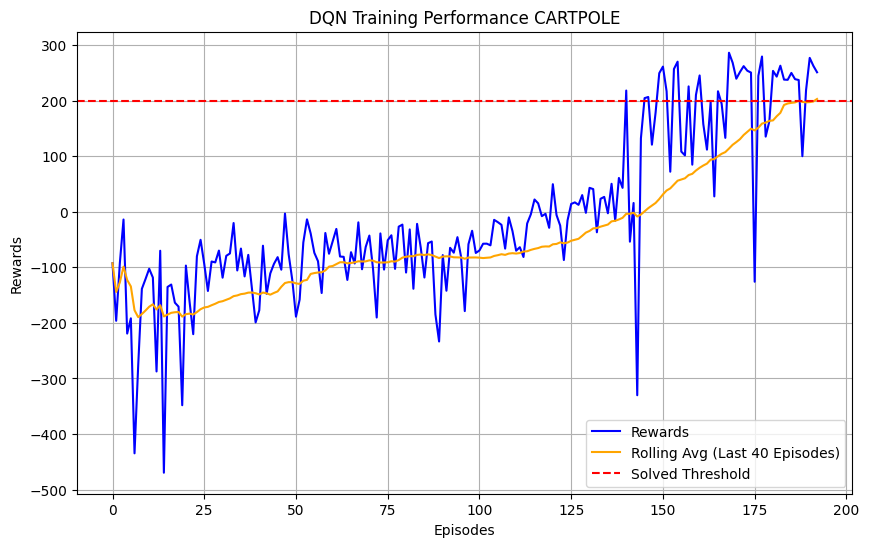

In [9]:
# Plot rewards with rolling average

plt.figure(figsize=(10, 6))
plt.plot(rewards_per_episode, label='Rewards', color='blue')
plt.plot(rolling_avg_rewards, label='Rolling Avg (Last '+str(ROLLING_WINDOW) +' Episodes)', color='orange')
plt.axhline(y=solved_threshold, color='red', linestyle='--', label='Solved Threshold')
plt.title('DQN Training Performance LUNARLANDER')
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.legend()
plt.grid()
plt.show()

#### **Simulation - Testing 10 episodes with the DQN Network**

In [10]:
# Testing for 10 episodes
start_time = time.time()

for e_test in range(10):  # Run 10 test episodes
    state, _ = env.reset()
    state = np.reshape(state, [1, state_size])
    total_reward = 0
    
    steps = 0
    while True:
        # Use the trained model for testing
        action = agent.action(state)  # Predict action values


        next_state, reward, done, truncated, _ = env.step(action)
        next_state = np.reshape(next_state, [1, state_size])
        total_reward += reward
        state = next_state
        steps = steps + 1
        if done or truncated:
            print(f"Test Episode: {e_test + 1:2}/10, Reward: {total_reward:.2f}, Steps: {steps:3}")
            break

end_time = time.time()
testing_duration = (end_time - start_time) / 60  # Convert to minutes
print(f"Testing completed in {testing_duration:.2f} minutes")

Test Episode:  1/10, Reward: 193.78, Steps: 520
Test Episode:  2/10, Reward: 221.69, Steps: 464
Test Episode:  3/10, Reward: 241.24, Steps: 412
Test Episode:  4/10, Reward: 238.59, Steps: 376
Test Episode:  5/10, Reward: 212.40, Steps: 461
Test Episode:  6/10, Reward: 222.79, Steps: 457
Test Episode:  7/10, Reward: 219.63, Steps: 610
Test Episode:  8/10, Reward: 229.64, Steps: 375
Test Episode:  9/10, Reward: 242.48, Steps: 442
Test Episode: 10/10, Reward: 263.40, Steps: 415
Testing completed in 2.56 minutes


#### **Rendering 1 episode**

In [11]:
# Test the trained agent with video rendering
# This code is useful if you are using colab otherwise use render_mode='human'
env = gym.make(("LunarLander-v3", render_mode='rgb_array')  # Enable RGB rendering
frames = []  # Store frames for visualization

# Render a single test episode
state, _ = env.reset()
state = np.reshape(state, [1, state_size])
tot_rewards = 0

while True:
    # Use the trained model for action
    action = agent.action(state)            # Predict action value

    next_state, reward, done, truncated, _ = env.step(action)
    frames.append(env.render())                  # Save frame for rendering later
    next_state = np.reshape(next_state, [1, state_size])
    tot_rewards += reward
    state = next_state

    if done or truncated:
        print(f"Rendered Test Episode Reward: {tot_rewards:.2f}")
        break

env.close()

# Save the rendered episode as a GIF
def save_frames_as_gif(frames, path='./', filename='LUNARLANDER_Agent_DQN.gif'):
    images = [Image.fromarray(frame) for frame in frames]
    gif_path = os.path.join(path, filename)
    images[0].save(gif_path, save_all=True, append_images=images[1:], duration=50, loop=0)
    print(f"Saved GIF to: {gif_path}")

save_frames_as_gif(frames, filename='LUNARLANDER_Agent_DQN.gif')


ValueError: cannot reshape array of size 4 into shape (1,8)

In [ ]:
import session_info
session_info.show(html=False)